<a href="https://www.kaggle.com/code/leekahwin/in-depth-8-models-to-predict-rent-80?scriptVersionId=103735663" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Notebook Author: Morris Lee
<br>
This notebook has implemented comprehensive regression learning models for housing rent, which has shows useful modelling functions to effectively train and evaluate learning models. It has also shows how to objectively identify standardisation or normalisation that can lead to perform the training better. After evaluating 8 diversified models, Voting Regressor is the best model due to having the best MAE, MSE, RMSE, R2 and Adj-R2

#### Preprocessing Part
* [Import Packages and Define Useful Functions](#0.1)
* [Cleaning Data](#0.2)
* [One-Hot-Encoding](#0.3)
    
#### Analysis Part
* [Univariate Analysis](#0.4)
* [Bivariate Analysis](#0.5)
* [Multivariate - Import Libraries and Train Test Split](#0.6)
* [Identify Important Variables](#0.7)
* [Define Evaluation Functions](#0.8)
* [10-fold Cross Validation to Know Normalisation or Standardisation](#0.9)
* [Evaluation of Prediction Performance on Unseen Data](#1.0)
* [Visualise Decision Tree and Extract Decision Rules](#1.1)
* [Concatenate Test Prediction Performance](#1.2)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.style.use('default')

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    if r:
        return vc_df
    else:
        print(f'STATUS: Value counts of "{column}"...')
        display(vc_df)
def one_hot_encode(df, column):
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(df[column])
    # Drop column as it is now encoded
    df = df.drop(column,axis = 1)
    print(f"one hot encoded {column}")
    # Join the encoded df
    df = df.join(one_hot)
    return df
def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df
df = pd.read_csv("/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv")
shape(df,'df')
df.head()

STATUS: Dimension of "df" = (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


# Cleaning Data <a class="anchor" id="0.2"></a>

In [2]:
# Trim the dataset.
shape(df,'df')
df2 = trim(df)
shape(df,'df')

# clean floor column
df2 = df2.join(df2['floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'floor_level', 1:'total_floor'}))
df2['floor_level'] = df2.apply(lambda x: 0 if x['floor_level'] =='Ground' \
                               else ( -1 if x['floor_level'] =='Lower Basement' else (x['total_floor']) ) , axis=1)
print("Status: Changed 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor")
df2.drop('floor',axis=1,inplace=True)

# dropna
df2 = df2.dropna()
shape(df,'df')

# change to correct data type
df2['floor_level'] = df2['floor_level'].astype('int64')
df2['total_floor'] = df2['total_floor'].astype('int64')

# Coerce datetime colume
df2['posted_on'] = pd.to_datetime(df2["posted_on"],errors='coerce')
display(df2.head())
df2.info()

# check value counts
for col in df2.select_dtypes(include=['object']).columns:
    vc(df2, col)

STATUS: Dimension of "df" = (4746, 12)
All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped
STATUS: Dimension of "df" = (4746, 12)
Status: Changed 'Ground'=0, 'Lower Basement'=-1, Rest = total_floor
STATUS: Dimension of "df" = (4746, 12)


,posted_on,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor
0,2022-05-18,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2
1,2022-05-13,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
2,2022-05-16,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3
3,2022-07-04,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2
4,2022-05-09,2,7500,850,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4742 entries, 0 to 4745
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   posted_on          4742 non-null   datetime64[ns]
 1   bhk                4742 non-null   int64         
 2   rent               4742 non-null   int64         
 3   size               4742 non-null   int64         
 4   area_type          4742 non-null   object        
 5   area_locality      4742 non-null   object        
 6   city               4742 non-null   object        
 7   furnishing_status  4742 non-null   object        
 8   tenant_preferred   4742 non-null   object        
 9   bathroom           4742 non-null   int64         
 10  point_of_contact   4742 non-null   object        
 11  floor_level        4742 non-null   int64         
 12  total_floor        4742 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 518.7+ 

,count,percentage (%)
area_type,,
Super Area,2444,51.539435
Carpet Area,2296,48.418389
Built Area,2,0.042176


STATUS: Value counts of "area_locality"...


,count,percentage (%)
area_locality,,
Bandra West,37,0.780261
Gachibowli,29,0.611556
Electronic City,24,0.506116
Velachery,22,0.463939
"Miyapur, NH 9",22,0.463939
...,...,...
Mandirtala,1,0.021088
"Mandakini Enclave, Alaknanda",1,0.021088
"DDA Akshardham Apartments, DS 19",1,0.021088


STATUS: Value counts of "city"...


,count,percentage (%)
city,,
Mumbai,972,20.497680
Chennai,891,18.789540
Bangalore,886,18.684100
Hyderabad,866,18.262337
Delhi,603,12.716154
Kolkata,524,11.050190


STATUS: Value counts of "furnishing_status"...


,count,percentage (%)
furnishing_status,,
Semi-Furnished,2250,47.448334
Unfurnished,1814,38.253901
Furnished,678,14.297765


STATUS: Value counts of "tenant_preferred"...


,count,percentage (%)
tenant_preferred,,
Bachelors/Family,3441,72.564319
Bachelors,830,17.503163
Family,471,9.932518


STATUS: Value counts of "point_of_contact"...


,count,percentage (%)
point_of_contact,,
Contact Owner,3212,67.735133
Contact Agent,1529,32.243779
Contact Builder,1,0.021088


In [3]:
# drop outliers
shape(df2,'df2')
df3 = df2[~df2['point_of_contact'].str.contains("Contact Builder")]
df3 = df3[~df3['area_type'].str.contains("Built Area")]
shape(df3,'df3')

area_locality_temp = vc(df3, 'area_locality',True)
area_locality_temp = area_locality_temp[area_locality_temp['count']==1]
print(f"Number of unique area_locality is {area_locality_temp.shape[0]} ")

# replace unique value to others
df3['area_locality'] = df3['area_locality'].replace(area_locality_temp.index, 'Others')
area_locality_temp = vc(df3, 'area_locality',True)

# extract date time
df3['month_posted'] = df3['posted_on'].dt.month
df3['day_posted'] = df3['posted_on'].dt.day
df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
df3['day_of_week_posted'] = df3['posted_on'].dt.day_of_week
df3['quarter_poster'] = df3['posted_on'].dt.quarter

# drop datetime
df3.drop('posted_on',axis=1,inplace=True)
df3.head()

STATUS: Dimension of "df2" = (4742, 13)
STATUS: Dimension of "df3" = (4739, 13)
Number of unique area_locality is 1461 


,bhk,rent,size,area_type,area_locality,city,furnishing_status,tenant_preferred,bathroom,point_of_contact,floor_level,total_floor,month_posted,day_posted,day_of_week_posted,quarter_poster
0,2,10000,1100,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,0,2,5,18,2,2
1,2,20000,800,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3,5,13,4,2
2,2,17000,1000,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,3,3,5,16,0,2
3,2,10000,800,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,2,2,7,4,0,3
4,2,7500,850,Carpet Area,Others,Kolkata,Unfurnished,Bachelors,1,Contact Owner,2,2,5,9,0,2


# One-Hot-Encoding <a class="anchor" id="0.3"></a>

In [4]:
df4 = df3.copy()
columns = ['area_type', 'city','furnishing_status','tenant_preferred','point_of_contact']
for col in columns:
    df4 = one_hot_encode(df4, col)
df4

one hot encoded area_type
one hot encoded city
one hot encoded furnishing_status
one hot encoded tenant_preferred
one hot encoded point_of_contact


,bhk,rent,size,area_locality,bathroom,floor_level,total_floor,month_posted,day_posted,day_of_week_posted,...,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family,Contact Agent,Contact Owner
0,2,10000,1100,Bandel,2,0,2,5,18,2,...,1,0,0,0,1,0,1,0,0,1
1,2,20000,800,"Phool Bagan, Kankurgachi",1,3,3,5,13,4,...,1,0,0,1,0,0,1,0,0,1
2,2,17000,1000,Salt Lake City Sector 2,1,3,3,5,16,0,...,1,0,0,1,0,0,1,0,0,1
3,2,10000,800,Dumdum Park,1,2,2,7,4,0,...,1,0,0,0,1,0,1,0,0,1
4,2,7500,850,Others,1,2,2,5,9,0,...,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,15000,1000,Bandam Kommu,2,5,5,5,18,2,...,0,0,0,1,0,0,1,0,0,1
4742,3,29000,2000,Others,3,4,4,5,15,6,...,0,0,0,1,0,0,1,0,0,1
4743,3,35000,1750,"Himayath Nagar, NH 7",3,5,5,7,10,6,...,0,0,0,1,0,0,1,0,1,0
4744,3,45000,1500,Gachibowli,2,34,34,7,6,2,...,0,0,0,1,0,0,0,1,1,0


# Univariate Analysis <a class="anchor" id="0.4"></a>

In [5]:
df4.rent.describe()

count    4.739000e+03
mean     3.502520e+04
std      7.815946e+04
min      1.200000e+03
25%      1.000000e+04
50%      1.600000e+04
75%      3.300000e+04
max      3.500000e+06
Name: rent, dtype: float64

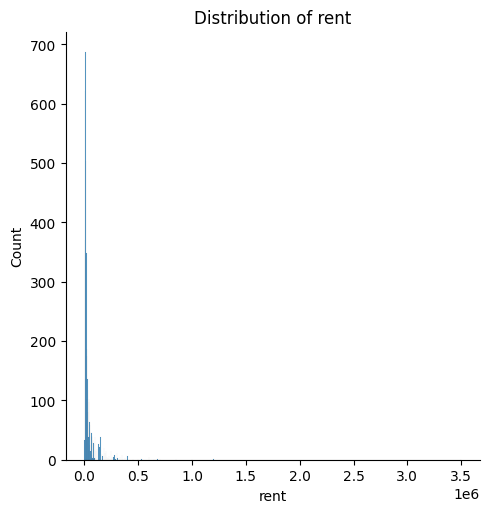

distribution highly skewed to the right


In [6]:
def vis_dist(df, col, lim=False):
    variable = df[col].values
    ax = sns.displot(variable)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    if lim:
        plt.xlim(0, 4000)
    return plt.show()
vis_dist(df4, 'rent')
print("distribution highly skewed to the right")

There are many sources has mentioned we can log transform skewed regression target variable for training the models.

Log Transformation


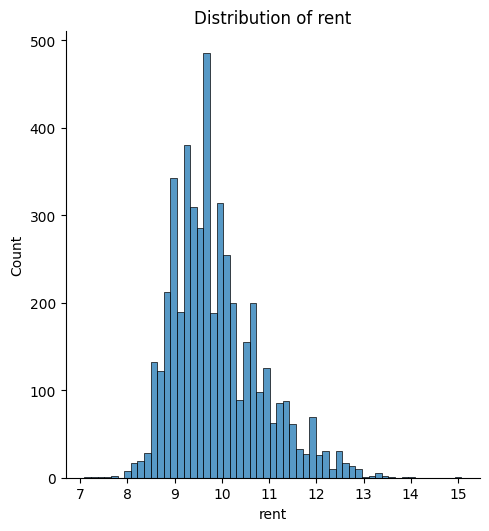

In [7]:
# log transform target
print("Log Transformation")
df4['rent'] = np.log1p(df4['rent'])
vis_dist(df4, 'rent')

# Bivariate Analysis <a class="anchor" id="0.5"></a>

In [8]:
# area_locality has too many unique value although has treated, so decided to drop it
df5 = df4.drop('area_locality', axis=1)
df5.corr()

,bhk,rent,size,bathroom,floor_level,total_floor,month_posted,day_posted,day_of_week_posted,quarter_poster,...,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Bachelors,Bachelors/Family,Family,Contact Agent,Contact Owner
bhk,1.000000,0.596434,0.716168,0.794829,0.246580,0.248057,0.122843,-0.052730,0.021853,0.123853,...,-0.050231,0.023339,0.042032,0.132826,-0.166754,0.033438,-0.104816,0.113870,0.231227,-0.231227
rent,0.596434,1.000000,0.567909,0.692269,0.559384,0.555309,0.208679,-0.051370,0.009874,0.194960,...,-0.273982,0.573771,0.207663,0.102071,-0.254417,0.083744,-0.168624,0.145140,0.617039,-0.617039
size,0.716168,0.567909,1.000000,0.740673,0.185644,0.189417,0.138383,-0.046907,0.008650,0.126091,...,-0.100327,-0.049626,0.051564,0.164168,-0.205825,0.034304,-0.094934,0.098029,0.214241,-0.214241
bathroom,0.794829,0.692269,0.740673,1.000000,0.362020,0.361965,0.163627,-0.066217,0.020914,0.155514,...,-0.213322,0.184110,0.075480,0.142600,-0.200883,0.031287,-0.119556,0.138588,0.327774,-0.327774
floor_level,0.246580,0.559384,0.185644,0.362020,1.000000,0.990092,0.172069,-0.051278,0.013339,0.171641,...,-0.184989,0.584276,0.062075,0.060419,-0.106783,0.012297,-0.111113,0.150119,0.469170,-0.469170
total_floor,0.248057,0.555309,0.189417,0.361965,0.990092,1.000000,0.173396,-0.053915,0.014318,0.173334,...,-0.169897,0.581102,0.059804,0.059301,-0.103999,0.009142,-0.108349,0.150005,0.465091,-0.465091
month_posted,0.122843,0.208679,0.138383,0.163627,0.172069,0.173396,1.000000,-0.524560,-0.015706,0.761839,...,-0.066311,0.118799,0.026275,0.038729,-0.058717,0.074426,-0.128110,0.096544,0.276593,-0.276593
day_posted,-0.052730,-0.051370,-0.046907,-0.066217,-0.051278,-0.053915,-0.524560,1.000000,-0.089572,-0.527399,...,0.039504,0.017611,0.000781,-0.027754,0.027957,0.003064,0.032824,-0.052856,-0.041735,0.041735
day_of_week_posted,0.021853,0.009874,0.008650,0.020914,0.013339,0.014318,-0.015706,-0.089572,1.000000,0.041170,...,0.044029,-0.005952,0.005222,-0.022298,0.019153,0.027560,-0.034057,0.015789,0.010192,-0.010192
quarter_poster,0.123853,0.194960,0.126091,0.155514,0.171641,0.173334,0.761839,-0.527399,0.041170,1.000000,...,-0.104979,0.096082,0.009366,0.063340,-0.071830,0.022924,-0.081211,0.092016,0.223578,-0.223578


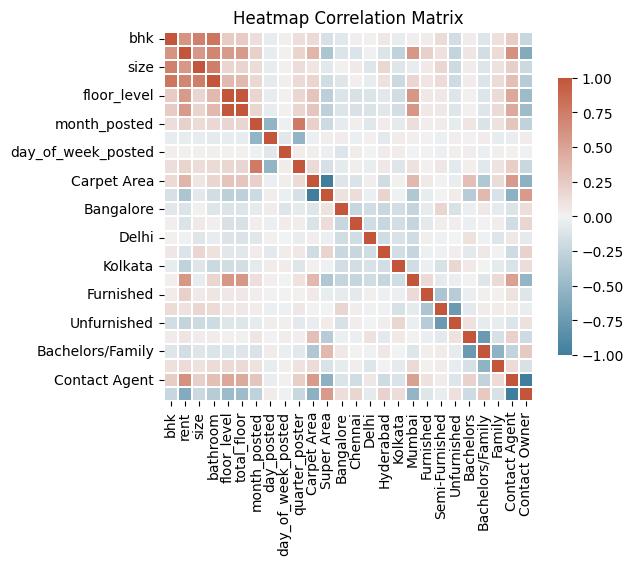

In [9]:
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=df5.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
plt.title(f'Heatmap Correlation Matrix')
# show the heatmap
plt.show()

In [10]:
def corr_sort_matrix(df, sort_desc, topn):
    corr_matrix = df.corr()
    if sort_desc == True:
        sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                          .stack()
                          .sort_values(ascending=False))
    else:
        sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=True))
    corr = pd.DataFrame(sol, columns=['corr']).reset_index()
    corr.columns = ['antecedent', 'consequent','correlation']
    return corr.head(topn)

# top positive correlated pairs
df_corr = corr_sort_matrix(df5, True, 10000)
df_corr.head(10)

,antecedent,consequent,correlation
0,floor_level,total_floor,0.990092
1,bhk,bathroom,0.794829
2,month_posted,quarter_poster,0.761839
3,size,bathroom,0.740673
4,bhk,size,0.716168
5,rent,bathroom,0.692269
6,rent,Contact Agent,0.617039
7,bhk,rent,0.596434
8,floor_level,Mumbai,0.584276
9,total_floor,Mumbai,0.581102


In [11]:
# top negative correlated pairs
df_corr = corr_sort_matrix(df5,False,10000)
df_corr.head(10)

,antecedent,consequent,correlation
0,Contact Agent,Contact Owner,-1.000000
1,Carpet Area,Super Area,-1.000000
2,Bachelors,Bachelors/Family,-0.749067
3,Semi-Furnished,Unfurnished,-0.748077
4,rent,Contact Owner,-0.617039
5,Carpet Area,Contact Owner,-0.561982
6,Super Area,Contact Agent,-0.561982
7,Bachelors/Family,Family,-0.540023
8,day_posted,quarter_poster,-0.527399
9,month_posted,day_posted,-0.524560


In [12]:
# top positive variables toward target
df_corr_y = df_corr[df_corr.consequent =='rent']
df_corr_y.head(10)

,antecedent,consequent,correlation
317,bhk,rent,0.596434


# Import Libraries and Train Test Split <a class="anchor" id="0.6"></a>

In [13]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn import tree
RANDOM_NUMBER = 42
y =df5[['rent']].values
X = df5.drop('rent',axis=1)

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_NUMBER)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    shape(X_train,'X_train') ; shape(X_test,'X_test') ; shape(y_train,'y_train') ; shape(y_test,'y_test')
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

STATUS: Dimension of "X_train" = (3791, 25)
STATUS: Dimension of "X_test" = (948, 25)
STATUS: Dimension of "y_train" = (3791,)
STATUS: Dimension of "y_test" = (948,)


# Identify Important Predictors <a class="anchor" id="0.7"></a>

In [14]:
# select attributes using Random Forest Regressor
def select_feature_dtc(X_train,y_train, selected_estimator):
    # get selector.threshold_
    selector = SelectFromModel(estimator=selected_estimator).fit(X_train, y_train)
    print(f'selector.threshold_ = {selector.threshold_}')

    feature_name = X_train.columns[selector.get_support()]
    print(f'Number of selected features = {feature_name.shape[0]}')

    # put it into a data frame
    d = {'columns': X_train.columns.tolist(),  'support':selector.get_support()}
    df = pd.DataFrame(data=d)
    df = df[df.support ==True]
    df.reset_index(inplace = True, drop=True)
    return df, feature_name

selected_estimator = RandomForestRegressor(random_state=RANDOM_NUMBER)
df, feature_name = select_feature_dtc(X_train, y_train, selected_estimator)
df

selector.threshold_ = 0.04
Number of selected features = 5


,columns,support
0,size,True
1,bathroom,True
2,Mumbai,True
3,Contact Agent,True
4,Contact Owner,True


# Define Evaluation Functions <a class="anchor" id="0.8"></a>

In [15]:
def test_predict(model,X_train,X_test,y_train,y_test, parameters = None):
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    model_text_list=[]; metric_list=[]; score_list=[] ; param_list=[]
    
    # create list of metric to be examined
    metric_functions = [r2_score, r2_score, mean_squared_error,mean_squared_error,mean_absolute_error]
    metric_functions_text = ['R_Squared', 'Adj_R_Squared', 'MSE','RMSE','MAE']
    
    # for loop of each of the 5 metrics
    for metric_function, metric_function_text in zip(metric_functions, metric_functions_text):
        if metric_function_text == 'Adj_R_Squared':
            Adj_r2 = 1 - (1-r2_score(y_test, prediction_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
            model_text_list.append(type(model).__name__); metric_list.append(metric_function_text); score_list.append(Adj_r2); param_list.append(parameters)
        elif metric_function_text == 'RMSE':
            rmse = mean_squared_error(y_test, prediction_test, squared=False)
            model_text_list.append(type(model).__name__); metric_list.append(metric_function_text); score_list.append(rmse); param_list.append(parameters)
        else:
            model_text_list.append(type(model).__name__); metric_list.append(metric_function_text); score_list.append(metric_function(y_test, prediction_test)); param_list.append(parameters) 
    
    d = {'model':model_text_list, 'parameters': param_list ,'metric': metric_list, 'test predict score': score_list}
    df = pd.DataFrame(data=d)
    return df

def five_cv_prarm_grid(PARAM_DICT, ESTIMATOR,X_train,y_train):
    sh = HalvingGridSearchCV(ESTIMATOR, PARAM_DICT, cv=10, scoring='neg_mean_absolute_error',min_resources="smallest",random_state=RANDOM_NUMBER).fit(X_train, y_train)
    best_estimator = sh.best_estimator_
    best_param = sh.best_params_
    print(best_estimator)
    print(f"10-CV Best Parameters = {best_param}")
    print(f"10-CV Best Score = {sh.best_score_}")
    return best_estimator, best_param

def cross_validation(model, treated_X, y):
    # drop na columns
    treated_X = treated_X.dropna(axis=1)
    # train test split
    X_train, X_test, y_train, y_test = split_data(treated_X, y)
    # cross validation
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    mean = scores.mean() ; std =scores.std()
    print(f"Average neg_mean_absolute_error: {mean}   , Std: {std}")
    print()
    return mean

# 10-fold Cross Validation to Know Normalisation or Standardisation <a class="anchor" id="0.9"></a>

In [16]:
model = RandomForestRegressor(random_state=RANDOM_NUMBER)

print("10 fold cross validation, where the higher the value, the better, this is because the MAE is negated")
print()

# normalisation (min max scalling)
print("normalisation (min max scalling)")
normalized_X = (X-X.min())/(X.max()-X.min())
norm_score = cross_validation(model, normalized_X, y)

# standardisation
print("standardisation")
standardized_X = (X-X.mean())/X.std()
std_score = cross_validation(model, standardized_X, y)

if norm_score> std_score:
    print(f"Normalisation is better than standardisation, where {norm_score}>{std_score}")
    print("Normalisation is chosen")
    X_train, X_test, y_train, y_test = split_data(normalized_X, y)
else:
    print(f"Standardisation is better than normalisation, where {std_score}>{norm_score}")
    print("Standardisation is chosen")
    X_train, X_test, y_train, y_test = split_data(standardized_X, y)

10 fold cross validation, where the higher the value, the better, this is because the MAE is negated

normalisation (min max scalling)
STATUS: Dimension of "X_train" = (3791, 25)
STATUS: Dimension of "X_test" = (948, 25)
STATUS: Dimension of "y_train" = (3791,)
STATUS: Dimension of "y_test" = (948,)
Average neg_mean_absolute_error: -0.29273689245722145   , Std: 0.008426496146235031

standardisation
STATUS: Dimension of "X_train" = (3791, 25)
STATUS: Dimension of "X_test" = (948, 25)
STATUS: Dimension of "y_train" = (3791,)
STATUS: Dimension of "y_test" = (948,)
Average neg_mean_absolute_error: -0.2926116743952658   , Std: 0.008600172542709188

Standardisation is better than normalisation, where -0.2926116743952658>-0.29273689245722145
Standardisation is chosen
STATUS: Dimension of "X_train" = (3791, 25)
STATUS: Dimension of "X_test" = (948, 25)
STATUS: Dimension of "y_train" = (3791,)
STATUS: Dimension of "y_test" = (948,)


# Evaluation of Prediction Performance on Unseen Data <a class="anchor" id="1.0"></a>

In [17]:
# LinearRegression
model = LinearRegression()
LinearRegression_test = test_predict(model, X_train,X_test,y_train,y_test)
LinearRegression_test

,model,parameters,metric,test predict score
0,LinearRegression,None,R_Squared,0.799635
1,LinearRegression,None,Adj_R_Squared,0.798573
2,LinearRegression,None,MSE,0.182204
3,LinearRegression,None,RMSE,0.426854
4,LinearRegression,None,MAE,0.306150


In [18]:
# BayesianRidge

model = BayesianRidge()

BayesianRidge_test = test_predict(model, X_train,X_test,y_train,y_test)
BayesianRidge_test

,model,parameters,metric,test predict score
0,BayesianRidge,None,R_Squared,0.799685
1,BayesianRidge,None,Adj_R_Squared,0.798623
2,BayesianRidge,None,MSE,0.182159
3,BayesianRidge,None,RMSE,0.426801
4,BayesianRidge,None,MAE,0.306103


In [19]:
# KNN Tune Parameter

PARAM_DICT = {'n_neighbors': [5,7,9,11,13],'weights': ['uniform', 'distance']}
ESTIMATOR =  KNeighborsRegressor()
best_KNN_estimator, best_param = five_cv_prarm_grid(PARAM_DICT, ESTIMATOR,X_train,y_train)

# test predict
KNN_test = test_predict(best_KNN_estimator, X_train,X_test,y_train,y_test, best_param)
KNN_test

KNeighborsRegressor(n_neighbors=7, weights='distance')
10-CV Best Parameters = {'n_neighbors': 7, 'weights': 'distance'}
10-CV Best Score = -0.38746085468706415


,model,parameters,metric,test predict score
0,KNeighborsRegressor,"{'n_neighbors': 7, 'weights': 'distance'}",R_Squared,0.752267
1,KNeighborsRegressor,"{'n_neighbors': 7, 'weights': 'distance'}",Adj_R_Squared,0.750953
2,KNeighborsRegressor,"{'n_neighbors': 7, 'weights': 'distance'}",MSE,0.225279
3,KNeighborsRegressor,"{'n_neighbors': 7, 'weights': 'distance'}",RMSE,0.474636
4,KNeighborsRegressor,"{'n_neighbors': 7, 'weights': 'distance'}",MAE,0.342279


In [20]:
# Decision Tree Tune Parameter

PARAM_DICT = {'max_depth': [None,3,4,5,6,7,8,9,10,11,15,20,25,30,35,40,45],'min_samples_split': [2,3,4,5],'min_samples_leaf':[1,2,3,4,5]}
ESTIMATOR =  DecisionTreeRegressor(random_state=RANDOM_NUMBER)
best_dtc_estimator, best_param = five_cv_prarm_grid(PARAM_DICT, ESTIMATOR,X_train,y_train)

# test predict
DTC_test = test_predict(best_dtc_estimator, X_train,X_test,y_train,y_test, best_param)
DTC_test

DecisionTreeRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=3,
                      random_state=42)
10-CV Best Parameters = {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 3}
10-CV Best Score = -0.34017340939277646


,model,parameters,metric,test predict score
0,DecisionTreeRegressor,"{'max_depth': 9, 'min_samples_leaf': 5, 'min_s...",R_Squared,0.772341
1,DecisionTreeRegressor,"{'max_depth': 9, 'min_samples_leaf': 5, 'min_s...",Adj_R_Squared,0.771133
2,DecisionTreeRegressor,"{'max_depth': 9, 'min_samples_leaf': 5, 'min_s...",MSE,0.207025
3,DecisionTreeRegressor,"{'max_depth': 9, 'min_samples_leaf': 5, 'min_s...",RMSE,0.455000
4,DecisionTreeRegressor,"{'max_depth': 9, 'min_samples_leaf': 5, 'min_s...",MAE,0.320766


In [21]:
# RandomForestRegressor Tune Parameter
PARAM_DICT = {'n_estimators': [10,50,100,200,300],'min_samples_leaf':[1,2,3]}
ESTIMATOR =  RandomForestRegressor(random_state=RANDOM_NUMBER)
best_rfc_estimator, best_param = five_cv_prarm_grid(PARAM_DICT, ESTIMATOR,X_train,y_train)

# test predict
RFC_test = test_predict(best_rfc_estimator, X_train,X_test,y_train, y_test, best_param)
RFC_test

RandomForestRegressor(random_state=42)
10-CV Best Parameters = {'min_samples_leaf': 1, 'n_estimators': 100}
10-CV Best Score = -0.3449299173809603


,model,parameters,metric,test predict score
0,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 100}",R_Squared,0.809831
1,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 100}",Adj_R_Squared,0.808822
2,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 100}",MSE,0.172933
3,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 100}",RMSE,0.415852
4,RandomForestRegressor,"{'min_samples_leaf': 1, 'n_estimators': 100}",MAE,0.294690


In [22]:
# Bagging Regressor

bagging_KNN = BaggingRegressor(best_KNN_estimator, max_samples=0.5, max_features=0.5, random_state=RANDOM_NUMBER)

# test predict
bagging_KNN_test = test_predict(bagging_KNN, X_train,X_test,y_train,y_test)
bagging_KNN_test

,model,parameters,metric,test predict score
0,BaggingRegressor,None,R_Squared,0.767311
1,BaggingRegressor,None,Adj_R_Squared,0.766076
2,BaggingRegressor,None,MSE,0.211599
3,BaggingRegressor,None,RMSE,0.459999
4,BaggingRegressor,None,MAE,0.332300


In [23]:
# Voting Regressor
model_voting = VotingRegressor(estimators = [('lr',LinearRegression()),('br', BayesianRidge()), ('knn', best_KNN_estimator), \
                                              ('dtc', best_dtc_estimator), \
                                              ('rfc', best_rfc_estimator)])

voting_test = test_predict(model_voting, X_train, X_test, y_train, y_test)
voting_test

,model,parameters,metric,test predict score
0,VotingRegressor,None,R_Squared,0.814819
1,VotingRegressor,None,Adj_R_Squared,0.813837
2,VotingRegressor,None,MSE,0.168397
3,VotingRegressor,None,RMSE,0.410362
4,VotingRegressor,None,MAE,0.290309


In [24]:
# Stacking Regressor
model_stacking = StackingRegressor(estimators = [('lr',LinearRegression()),('br', BayesianRidge()), ('knn', best_KNN_estimator), \
                                              ('dtc', best_dtc_estimator), \
                                              ('rfc', best_rfc_estimator)], final_estimator=KNeighborsRegressor())

stacking_test = test_predict(model_stacking, X_train, X_test, y_train, y_test)
stacking_test

,model,parameters,metric,test predict score
0,StackingRegressor,None,R_Squared,0.787508
1,StackingRegressor,None,Adj_R_Squared,0.786381
2,StackingRegressor,None,MSE,0.193233
3,StackingRegressor,None,RMSE,0.439583
4,StackingRegressor,None,MAE,0.320208


# Visualise Decision Tree and Extract Decision Rules <a class="anchor" id="1.1"></a>

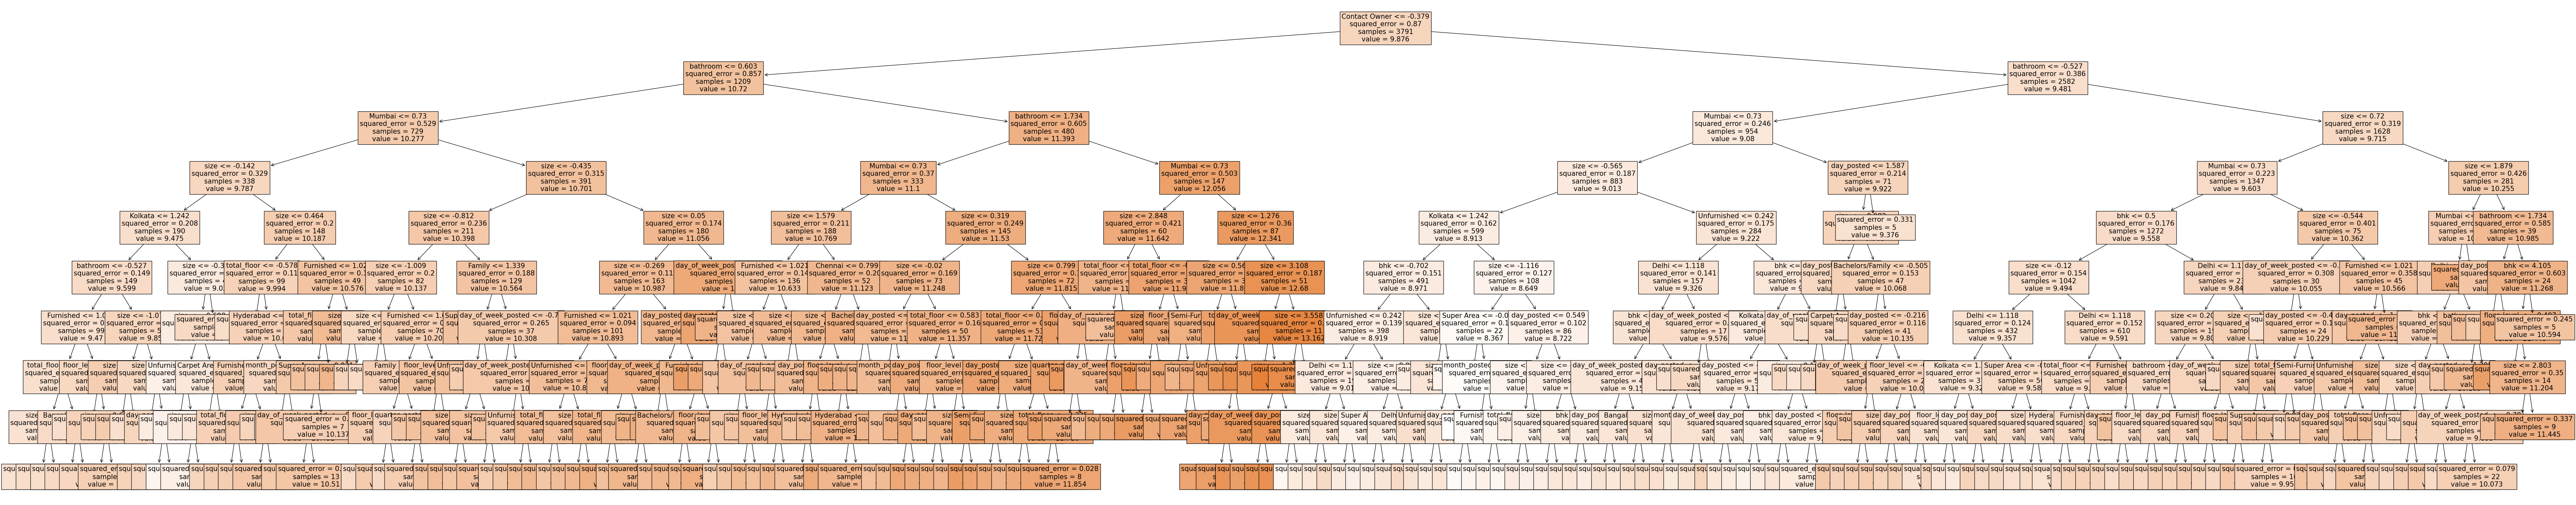

In [25]:
attribute_names=X_train.columns.tolist()
label_names=False

plt.figure(figsize=(100,20))
tree.plot_tree(best_dtc_estimator, 
                   feature_names =attribute_names,  
                   class_names=label_names,
                   filled=True, fontsize=15)
plt.show()

In [26]:
text_representation = tree.export_text(best_dtc_estimator, feature_names=attribute_names)
print(text_representation)

|--- Contact Owner <= -0.38
|   |--- bathroom <= 0.60
|   |   |--- Mumbai <= 0.73
|   |   |   |--- size <= -0.14
|   |   |   |   |--- Kolkata <= 1.24
|   |   |   |   |   |--- bathroom <= -0.53
|   |   |   |   |   |   |--- Furnished <= 1.02
|   |   |   |   |   |   |   |--- total_floor <= -0.26
|   |   |   |   |   |   |   |   |--- size <= -0.56
|   |   |   |   |   |   |   |   |   |--- value: [9.30]
|   |   |   |   |   |   |   |   |--- size >  -0.56
|   |   |   |   |   |   |   |   |   |--- value: [9.53]
|   |   |   |   |   |   |   |--- total_floor >  -0.26
|   |   |   |   |   |   |   |   |--- Bangalore <= 0.80
|   |   |   |   |   |   |   |   |   |--- value: [9.45]
|   |   |   |   |   |   |   |   |--- Bangalore >  0.80
|   |   |   |   |   |   |   |   |   |--- value: [9.68]
|   |   |   |   |   |   |--- Furnished >  1.02
|   |   |   |   |   |   |   |--- floor_level <= -0.30
|   |   |   |   |   |   |   |   |--- value: [9.44]
|   |   |   |   |   |   |   |--- floor_level >  -0.30
|   |   |   | 

# Concatenate Test Prediction Performance <a class="anchor" id="1.2"></a>

In [27]:
def concat_results(results_test):
    temp=[]
    for result in results_test:
        temp.append(result.pivot(index='model', columns='metric', values='test predict score').reset_index())
    merged = pd.concat(temp)
    for col in merged.columns.values:
        if col != 'model':
            if col == 'Adj_R_Squared' or col == 'R_Squared':
                best_model = merged[merged[col]==merged[col].max()].model.values[0]
                print(f"Best model for {col} = {best_model}")
            else:
                best_model = merged[merged[col]==merged[col].min()].model.values[0]
                print(f"Best model for {col} = {best_model}")
        else:
            pass
    display(merged)
    return merged

results_test = [LinearRegression_test, BayesianRidge_test, KNN_test, DTC_test, \
                RFC_test, bagging_KNN_test, voting_test, stacking_test]

merged_result_customer  = concat_results(results_test)


Best model for Adj_R_Squared = VotingRegressor
Best model for MAE = VotingRegressor
Best model for MSE = VotingRegressor
Best model for RMSE = VotingRegressor
Best model for R_Squared = VotingRegressor


metric,model,Adj_R_Squared,MAE,MSE,RMSE,R_Squared
0,LinearRegression,0.798573,0.306150,0.182204,0.426854,0.799635
0,BayesianRidge,0.798623,0.306103,0.182159,0.426801,0.799685
0,KNeighborsRegressor,0.750953,0.342279,0.225279,0.474636,0.752267
0,DecisionTreeRegressor,0.771133,0.320766,0.207025,0.455000,0.772341
0,RandomForestRegressor,0.808822,0.294690,0.172933,0.415852,0.809831
0,BaggingRegressor,0.766076,0.332300,0.211599,0.459999,0.767311
0,VotingRegressor,0.813837,0.290309,0.168397,0.410362,0.814819
0,StackingRegressor,0.786381,0.320208,0.193233,0.439583,0.787508


Voting Regressor is the best model due to the best MAE, MSE, RMSE, R2 and Adj-R2
<br>
-Morris Lee (20/8/2022)